In [8]:
!pip install tldextract

In [10]:
!pip install xgboost

In [7]:
!pip install imblearn

In [14]:
df = pd.read_csv(filename)
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [12]:
import pandas as pd
import numpy as np
import re
import math
import requests
import tldextract
from urllib.parse import urlparse
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score,confusion_matrix, classification_report, log_loss, mean_squared_error, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split

from xgboost import XGBClassifier

import imblearn
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks

In [15]:
filename = "/Users/yaeerk/Documents/NAYA/FinalProject/malicious_phish.csv"

In [16]:
#attribute listed_in_top_domain numeric
text = requests.get('http://www.iana.org/domains/root/db').text #Get main domains

In [6]:
#attribute contains https numeric
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        return 1
    else:
        return 0

In [8]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0

In [ ]:
#attribute num_digit numeric
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
#attribute num_letter numeric
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
#Is the url contains shortening service
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
#Is the url have an ip address
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [ ]:
df = pd.read_csv(filename)
df.head()

In [7]:
df['https']                = df['url'].apply(lambda i: httpSecure(i))
df['abnormal_url']         = df['url'].apply(lambda i: abnormal_url(i))
df['letters']              = df['url'].apply(lambda i: letter_count(i))
df['digits']               = df['url'].apply(lambda i: digit_count(i))
df['Shortining_Service']   = df['url'].apply(lambda x: Shortining_Service(x))
df['having_ip_address']    = df['url'].apply(lambda i: having_ip_address(i))
df['url_length']           = [len(x) for x in df.url] #attribute url_length numeric
df['num_tokens']           = [len(re.findall(r'\w+', x)) for x in df.url] #attribute num_tokens numeric
df['listed_in_top_domain'] = [1 if tldextract.extract(x).domain in text else 0 for x in df.url]  #attribute is main domain numeric
df['label']                = [1 if i == "benign" else 0 for i in df.type] # Converting label to int

#attribute num_symbol numeric
symbol = ['&','/','\\',';','_','@','?','-','=','.','#','%','+','$','!','*',',','//']
for i in symbol:
    name = 'num_of_' + i 
    df[name] = [x.count(i) for x in df.url]

<AxesSubplot:>

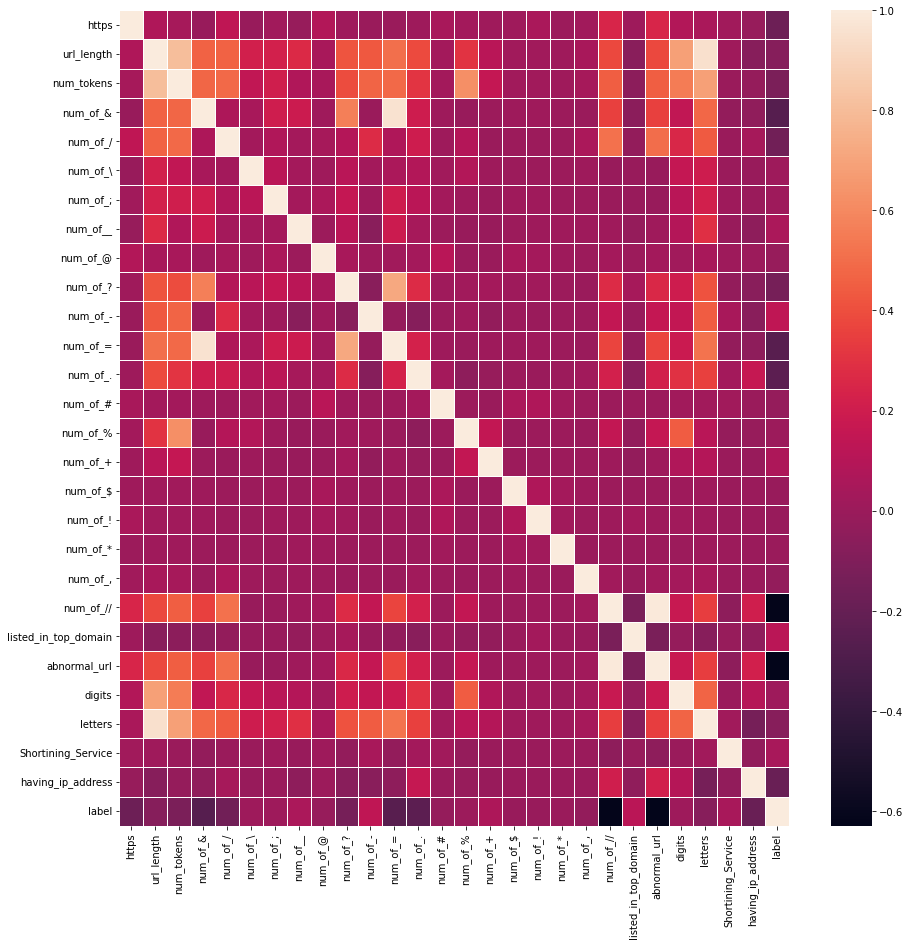

In [11]:
plt.figure(figsize = (15, 15))
sns.heatmap(df.corr(), linewidths = 0.5)

In [ ]:
df.label.value_counts()

In [13]:
X = df.drop(['url','label','type'],axis=1)
y = df['label']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [15]:
#oversampling
sm = SMOTE(random_state = 2)

In [ ]:
y_train.value_counts()

In [107]:
models = [DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, XGBClassifier]
scale_pos_weight = y.value_counts()[1] / y.value_counts()[0]
accuracy_test, feature_importance, tab = [], [], ' '

for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    if (m == RandomForestClassifier):
            model_ = RandomForestClassifier(max_depth = 80, max_features = 2, min_samples_leaf = 3, min_samples_split = 8)
            model_.fit(X_train, y_train)
    else:
        model_ = m()
        model_.fit(X_train, y_train)

    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    feature_im = model_.feature_importances_
    feature_importance.append(feature_im)
    rmse_train, rmse_test = math.sqrt(mean_squared_error(y_train, model_.predict(X_train))), math.sqrt(mean_squared_error(y_test, model_.predict(X_test))) 
    print(tab * 6 + "rmse_train", rmse_train)
    print(tab * 6 + "rmse_test", rmse_test)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
   

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
      rmse_train 0.17052699064100754
      rmse_test 0.22689705792410975
Test Accuracy :  94.85%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     44674
           1       0.96      0.96      0.96     85565

    accuracy                           0.95    130239
   macro avg       0.94      0.94      0.94    130239
weighted avg       0.95      0.95      0.95    130239

             Confusion_matrix 
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
      rmse_train 0.24358111965293983
      rmse_test 0.2471747778764348
Test Accuracy :  93.89%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     44674
           1       0.92

In [51]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','Extra Trees Classifier','XGBClassifier'], "Accuracy":accuracy_test})

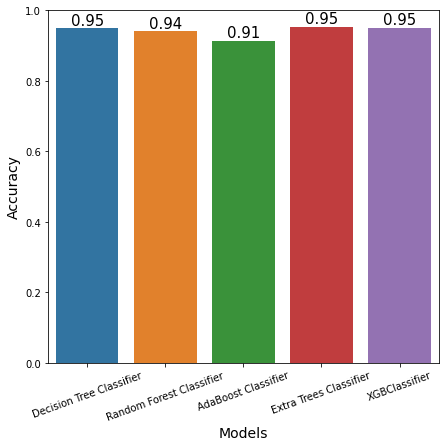

In [44]:
plt.figure(figsize = (7, 6.5))
plots = sns.barplot(x = 'Model', y = 'Accuracy', data = output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha = 'center', va = 'center',
                   size = 15, xytext = (0, 8),
                   textcoords = 'offset points')

plt.xlabel("Models", size = 14)
plt.xticks(rotation = 20);
plt.ylabel("Accuracy", size = 14)
plt.show()

In [143]:
dict1 = {}
model_str = ['Decision Tree Classifier','Random Forest Classifier','AdaBoost Classifier','Extra Trees Classifier','XGBClassifier']
for i, j in enumerate(model_str):
    dict1[j] = feature_importances[i]
    
feature_dataframe = pd.DataFrame(dict1)
feature_dataframe['mean'] = feature_dataframe.mean(axis = 1) # axis = 1 computes the mean row-wise
feature_dataframe['Feature'] = X_test.columns
feature_dataframe = feature_dataframe.sort_values(by = 'mean',ascending = False)
feature_dataframe.head()

,Decision Tree Classifier,Random Forest Classifier,AdaBoost Classifier,Extra Trees Classifier,XGBClassifier,mean,Feature
22,0.435515,0.212931,0.12,0.326353,0.746353,0.368231,abnormal_url
4,0.174715,0.140915,0.12,0.147170,0.038840,0.124328,num_of_/
12,0.078742,0.114185,0.14,0.086584,0.031413,0.090185,num_of_.
10,0.075266,0.036547,0.12,0.051064,0.026993,0.061974,num_of_-
1,0.088410,0.047603,0.06,0.053504,0.026037,0.055111,url_length


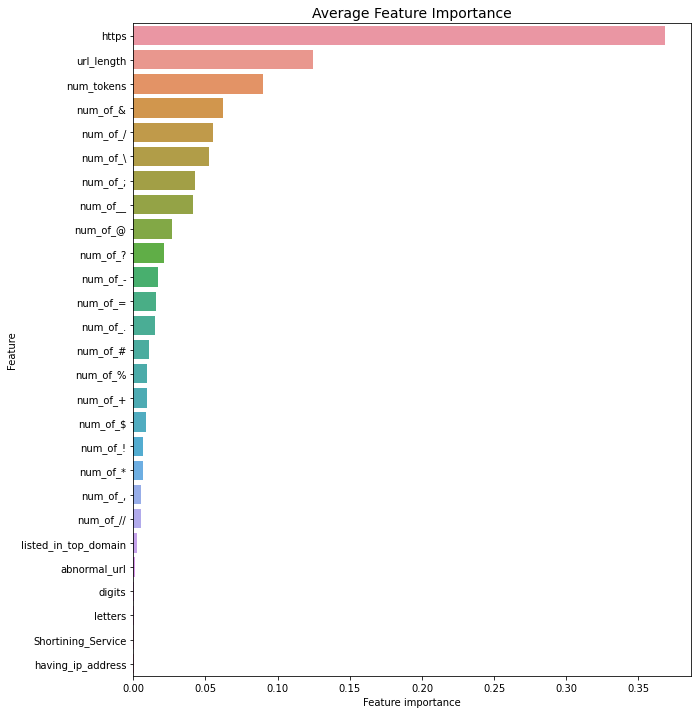

In [145]:
def plot_feature_importance():
    tmp = pd.DataFrame({'Feature': X_test.columns, 'Feature importance': feature_dataframe['mean'].values})
    plt.figure(figsize = (10, 12))
    plt.title('Average Feature Importance',fontsize = 14)
    s = sns.barplot(y = 'Feature',x = 'Feature importance', data = tmp, orient = 'h')
    plt.show()
plot_feature_importance()